In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 40.0 MB/s eta 0:00:00


In [4]:
save_path = '/content/drive/MyDrive/'
save_path1 = '/content/drive/MyDrive/'

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
import tensorflow as tf
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
import shutil
import pathlib
import random

#model selection
from sklearn.model_selection import train_test_split

#data augumentation
import  cv2
import imgaug
import imageio
from imgaug import augmenters as iaa

##
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.applications import vgg16
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras import layers

In [7]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from tqdm.notebook import tqdm
from zipfile import ZipFile
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
!unzip /content/drive/MyDrive/NewDataset.zip

Archive:  /content/drive/MyDrive/NewDataset.zip
  inflating: NewData/TestLabels.npy  
  inflating: NewData/ValLabels.npy   
  inflating: NewData/TrainLabels.npy  
  inflating: NewData/ValData.npy     
  inflating: NewData/TestData.npy    
  inflating: NewData/TrainData.npy   


In [10]:
#Run from here
import os
x_train = []
y_train = []
x_train = np.load("/content/NewData/TrainData.npy")
y_train = np.load("/content/NewData/TrainLabels.npy")

x_val = []
y_val = []
x_val = np.load("/content/NewData/ValData.npy")
y_val = np.load("/content/NewData/ValLabels.npy")

x_test = []
y_test = []
x_test = np.load("/content/NewData/TestData.npy")
y_test = np.load("/content/NewData/TestLabels.npy")

print(f"x_train shape: {x_train .shape} - y_train shape: {y_train .shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test .shape}")

x_train shape: (18123, 110, 110, 3) - y_train shape: (18123,)
x_val shape: (648, 110, 110, 3) - y_val shape: (648,)
x_test shape: (812, 110, 110, 3) - y_test shape: (812,)


In [11]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

data_augmentation.layers[0].adapt(x_train)

In [12]:
img_heigth, img_width = 110,110
input_shape = (img_heigth, img_width, 3)
num_classes = 5

In [13]:
def create_encoder():
    vgg16 = keras.applications.VGG19(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = vgg16(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="vgg19-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.0001
batch_size = 32
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "vgg19-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     7         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
Total params: 20,024,391
Trainable params: 20,024,384
Non-trainable params: 7
_________________________________________________________________


In [14]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="vgg19-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [15]:
checkpointer = ModelCheckpoint(filepath='saved_models/baseline_model_vgg19.hdf5', 
                               monitor='sparse_categorical_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs,callbacks=callbacks)

Model: "vgg19-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 vgg19-encoder (Functional)  (None, 512)               20024391  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 20,289,612
Trainable params: 20,289,

In [ ]:
classifier.save(save_path + 'Contrastive_Baseline_vgg19.h5')
classifier.save_weights(save_path1 + "Weights_Contrastive_Baseline_vgg19.h5")

In [ ]:
vgg19_base_trainloss_dict = {}
vgg19_base_valloss_dict = {}

In [ ]:
import pickle

with open('/content/drive/MyDrive/vgg19_base_train_loss.pkl', 'wb') as file:
    pickle.dump(vgg19_base_trainloss_dict, file)

with open('/content/drive/MyDrive/vgg19_base_val_loss.pkl', 'wb') as file:
    pickle.dump(vgg19_base_valloss_dict, file)

26/26 [==============================] - 2s 70ms/step


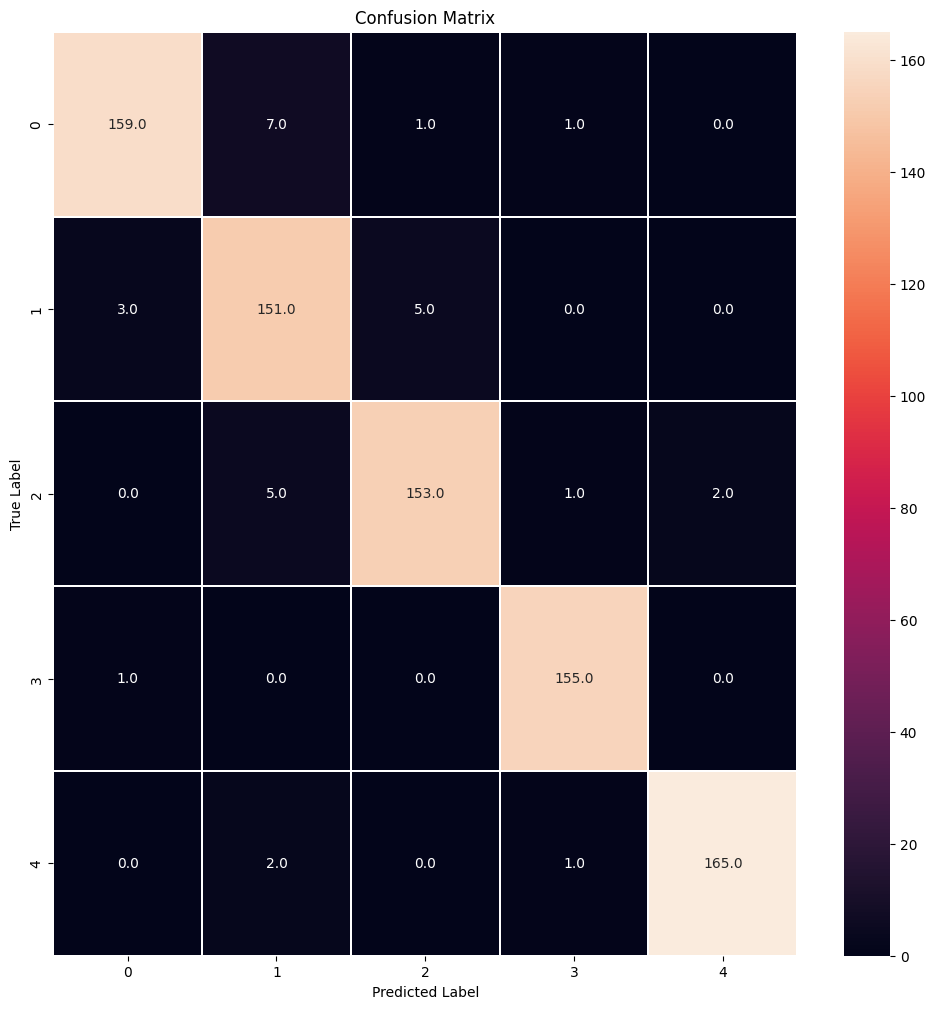

In [ ]:
pred = classifier.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#ax.xaxis.set_ticklabels(x_test.class_indices)
#ax.yaxis.set_ticklabels(y_test)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_base = classification_report(y_test, y_pred, output_dict=True)
df12 = pd.DataFrame(report_base).transpose()
df12

,precision,recall,f1-score,support
0,0.946429,0.975460,0.960725,163.000000
1,0.949686,0.915152,0.932099,165.000000
2,0.950311,0.962264,0.956250,159.000000
3,0.993590,0.981013,0.987261,158.000000
4,0.982143,0.988024,0.985075,167.000000
accuracy,0.964286,0.964286,0.964286,0.964286
macro avg,0.964431,0.964382,0.964282,812.000000
weighted avg,0.964372,0.964286,0.964203,812.000000


In [ ]:
from tensorflow.keras.models import load_model
baseline_VGG16=load_model(save_path + 'Contrastive_Baseline_vgg19.h5')


In [ ]:
accuracy = baseline_VGG16.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

26/26 [==============================] - 2s 45ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9643
Test accuracy: 96.43%


In [ ]:
classifier=baseline_VGG16
y_predict = np.argmax(classifier.predict(x_test), axis=-1)

26/26 [==============================] - 1s 43ms/step


26/26 [==============================] - 1s 43ms/step


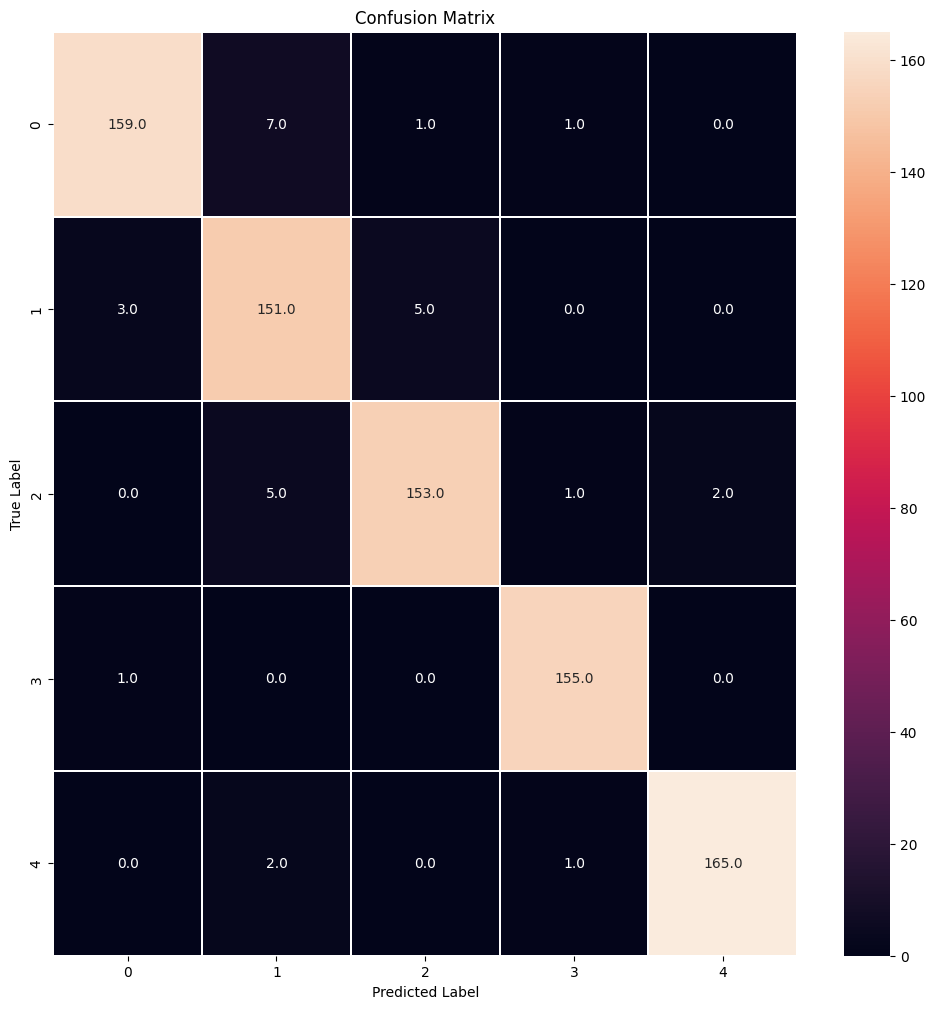

In [ ]:
cancer_classes=np.unique(y_test)

pred = baseline_VGG16.predict(x_test)

y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report_base = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df12 = pd.DataFrame(report_base).transpose()
df12

,precision,recall,f1-score,support
0,0.946429,0.975460,0.960725,163.000000
1,0.949686,0.915152,0.932099,165.000000
2,0.950311,0.962264,0.956250,159.000000
3,0.993590,0.981013,0.987261,158.000000
4,0.982143,0.988024,0.985075,167.000000
accuracy,0.964286,0.964286,0.964286,0.964286
macro avg,0.964431,0.964382,0.964282,812.000000
weighted avg,0.964372,0.964286,0.964203,812.000000


# N-pair loss

In [16]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="vgg19-encoder_with_projection-head"
    )
    return model

In [17]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "vgg19-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 110, 110, 3)]     0         
                                                                 
 vgg19-encoder (Functional)  (None, 512)               20024391  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
Total params: 20,090,055
Trainable params: 20,090,048
Non-trainable params: 7
_________________________________________________________________
Epoch 1/50
567/567 [==============================] - 973s 2s/step - loss: 3.4329
Epoch 2/50
567/567 [==============================] - 529s 931ms/step - loss: 3.3140
Epoch 3/50
567/567 [==============================] - 339s 597ms/step - loss: 3.2629
Epoch 4/50
567/567 [============

In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models/Contrastive_npairloss_vgg19.h5', 
                               monitor='sparse_categorical_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=2, min_lr=1e-5)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [19]:
encoder_with_projection_head.save(save_path + 'Contrastive_npairloss_vgg19.h5')
encoder_with_projection_head.save_weights(save_path1 + "Weights_Contrastive_npairloss_vgg19.h5")

In [20]:
vgg19_npair_trainloss_dict = {}
vgg19_npair_valloss_dict = {}

In [21]:
import pickle

with open('/content/drive/MyDrive/vgg19_npair_trainloss_dict.pkl', 'wb') as file:
    pickle.dump(vgg19_npair_trainloss_dict, file)

with open('/content/drive/MyDrive/vgg19_npair_valloss_dict.pkl', 'wb') as file:
    pickle.dump(vgg19_npair_valloss_dict, file)

In [22]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs,callbacks=callbacks)

Epoch 1/50
567/567 [==============================] - ETA: 0s - loss: 12.0099 - sparse_categorical_accuracy: 0.8525
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.85251, saving model to saved_models/Contrastive_npairloss_vgg19.h5
567/567 [==============================] - 27s 43ms/step - loss: 12.0099 - sparse_categorical_accuracy: 0.8525 - lr: 1.0000e-04
Epoch 2/50
567/567 [==============================] - ETA: 0s - loss: 3.4187 - sparse_categorical_accuracy: 0.9372
Epoch 2: sparse_categorical_accuracy improved from 0.85251 to 0.93715, saving model to saved_models/Contrastive_npairloss_vgg19.h5
567/567 [==============================] - 25s 43ms/step - loss: 3.4187 - sparse_categorical_accuracy: 0.9372 - lr: 1.0000e-04
Epoch 3/50
567/567 [==============================] - ETA: 0s - loss: 3.0023 - sparse_categorical_accuracy: 0.9406
Epoch 3: sparse_categorical_accuracy improved from 0.93715 to 0.94057, saving model to saved_models/Contrastive_npairloss_vgg19.h5
567/567 [

In [23]:
classifier.save(save_path + 'Contrastive_npair_vgg19.h5')
classifier.save_weights(save_path1 + "Weights_Contrastive_npair_vgg19.h5")

In [24]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

26/26 [==============================] - 2s 64ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.9667
Test accuracy: 96.67%


In [25]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)

26/26 [==============================] - 1s 38ms/step


In [26]:
confusion_matrix(y_test, y_predict)

array([[158,   4,   0,   1,   0],
       [  1, 156,   7,   0,   1],
       [  1,   3, 153,   1,   1],
       [  2,   1,   1, 154,   0],
       [  0,   1,   2,   0, 164]])

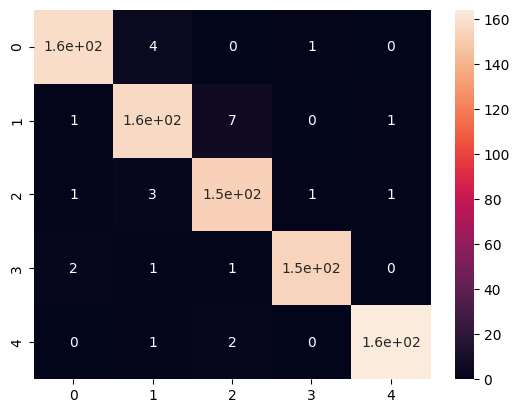

In [27]:
cm = confusion_matrix(y_test, y_predict)
f = sns.heatmap(cm, annot=True)

In [28]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       163
           1       0.95      0.95      0.95       165
           2       0.94      0.96      0.95       159
           3       0.99      0.97      0.98       158
           4       0.99      0.98      0.98       167

    accuracy                           0.97       812
   macro avg       0.97      0.97      0.97       812
weighted avg       0.97      0.97      0.97       812



In [29]:
classifier.save(save_path + 'Contrastive_npair_vgg19.h5')
classifier.save_weights(save_path1 + "Weights_Contrastive_npair_vgg19.h5")

In [30]:
npair_VGG16=load_model(save_path + 'Contrastive_npair_vgg19.h5')

In [31]:
accuracy = npair_VGG16.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

26/26 [==============================] - 1s 43ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.9667
Test accuracy: 96.67%


26/26 [==============================] - 2s 45ms/step


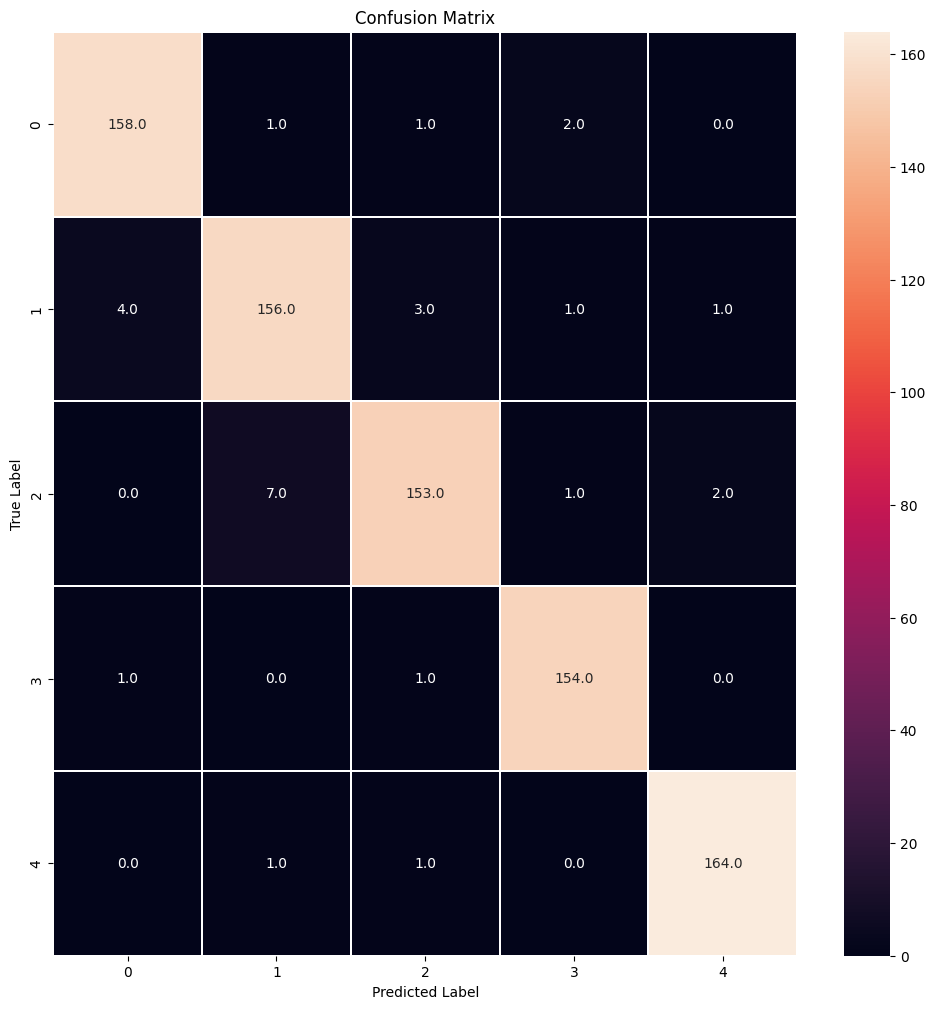

In [32]:
pred = npair_VGG16.predict(x_test)
cancer_classes=np.unique(y_test)
y_pred = np.argmax(pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_test)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(cancer_classes)
ax.yaxis.set_ticklabels(cancer_classes)
plt.title("Confusion Matrix")
plt.show()

In [33]:
report_npair = classification_report(y_test, y_pred, target_names=cancer_classes, output_dict=True)
df2 = pd.DataFrame(report_npair).transpose()
df2

,precision,recall,f1-score,support
0,0.975309,0.969325,0.972308,163.000000
1,0.945455,0.945455,0.945455,165.000000
2,0.938650,0.962264,0.950311,159.000000
3,0.987179,0.974684,0.980892,158.000000
4,0.987952,0.982036,0.984985,167.000000
accuracy,0.966749,0.966749,0.966749,0.966749
macro avg,0.966909,0.966753,0.966790,812.000000
weighted avg,0.966974,0.966749,0.966821,812.000000
